<h1> <center> 4 - Bills </center> </h1> 

**Authors:** Sebastião Rosalino, Flávio Pinheiro, António Curado

# Table of Contents

1. [Votes](#Votes)
2. [Votes ID URL Mapping](#Votes-ID-URL-Mapping)
3. [Votes Extract](#Votes-Extract)
4. [Bills](#Bills)
   - 4.1. [Text Cleaning](#Text-Cleaning)
   - 4.2. [Stopwords Removal](#Stopwords-Removal)
   - 4.3. [Lemmatization](#Lemmatization)
   - 4.4. [Bill Text Exploration](#Bill-Text-Exploration)
5. [Exporting Dataset](#Exporting-Dataset)

In [1]:
# Import the necessary libraries and configurations
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import warnings
import re
import spacy
import pickle

from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from tqdm import tqdm

# Suppress all warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the votes, votes_id_url_mapping and votes_extract datasets
votes = pd.read_csv('../datasets/first_stage/votes.csv')
votes_id_url_mapping = pd.read_csv('../datasets/first_stage/vote_id_url_mapping.csv')
votes_extract = pd.read_csv('../datasets/first_stage/votes_extract.csv')

In [3]:
# Check the shape (number of rows and number of features) of each loaded dataset
print(f'votes number of rows: {votes.shape[0]}')
print(f'votes number of features: {votes.shape[1]}')

print('\n')

print(f'votes_id_url_mapping number of rows: {votes_id_url_mapping.shape[0]}')
print(f'votes_id_url_mapping number of features: {votes_id_url_mapping.shape[1]}')

print('\n')

print(f'votes_extract number of rows: {votes_extract.shape[0]}')
print(f'votes_extract number of features: {votes_extract.shape[1]}')

votes number of rows: 19218
votes number of features: 9


votes_id_url_mapping number of rows: 1780
votes_id_url_mapping number of features: 2


votes_extract number of rows: 1603
votes_extract number of features: 17


In [4]:
# Check the structural information of the votes dataset, including column names, non-null counts, datatypes and size
votes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19218 entries, 0 to 19217
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   19218 non-null  int64 
 1   timestamp            19218 non-null  object
 2   display_title        19185 non-null  object
 3   reference            18709 non-null  object
 4   description          18695 non-null  object
 5   is_main              19218 non-null  bool  
 6   is_featured          19218 non-null  bool  
 7   procedure_reference  18358 non-null  object
 8   procedure_title      18637 non-null  object
dtypes: bool(2), int64(1), object(6)
memory usage: 1.1+ MB


In [5]:
# Check for duplicated rows in the votes dataset
duplicates = votes.duplicated()

# Display the count of duplicated rows
print(f"Number of duplicated rows in votes: {duplicates.sum()}")

Number of duplicated rows in votes: 0


In [6]:
# Check the structural information of the votes_id_url_mapping dataset, including column names, non-null counts, datatypes and size
votes_id_url_mapping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1780 entries, 0 to 1779
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1780 non-null   int64 
 1   url     1780 non-null   object
dtypes: int64(1), object(1)
memory usage: 27.9+ KB


In [7]:
# Check for duplicated rows in the votes_id_url_mapping dataset
duplicates = votes_id_url_mapping.duplicated()

# Display the count of duplicated rows
print(f"Number of duplicated rows in votes_id_url_mapping: {duplicates.sum()}")

Number of duplicated rows in votes_id_url_mapping: 0


In [8]:
# Check the structural information of the votes_extract dataset, including column names, non-null counts, datatypes and size
votes_extract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1603 entries, 0 to 1602
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   content                     1476 non-null   object 
 1   markdown                    1476 non-null   object 
 2   metadata_title              1476 non-null   object 
 3   metadata_description        1470 non-null   object 
 4   metadata_robots             1476 non-null   object 
 5   metadata_ogTitle            1476 non-null   object 
 6   metadata_ogImage            1476 non-null   object 
 7   metadata_ogLocaleAlternate  1476 non-null   object 
 8   metadata_sourceURL          1476 non-null   object 
 9   metadata_pageStatusCode     1476 non-null   float64
 10  linksOnPage                 1476 non-null   object 
 11  comitee                     1333 non-null   object 
 12  legislative_content         1493 non-null   object 
 13  proponents                  1603 

In [9]:
# Check for duplicated rows in the votes_extract dataset
duplicates = votes_extract.duplicated()

# Display the count of duplicated rows
print(f"Number of duplicated rows in votes_extract: {duplicates.sum()}")

Number of duplicated rows in votes_extract: 0


## 1. Votes
<a id="Votes"></a>

In [10]:
# Visualize the votes dataset
votes

,id,timestamp,display_title,reference,description,is_main,is_featured,procedure_reference,procedure_title
0,108425,2019-07-15 17:09:37,Mardi - demande du groupe GUE/NGL,NaN,NaN,False,False,NaN,NaN
1,108530,2019-07-18 11:30:02,Resolution on the situation in Venezuela,RC-B9-0006/2019,§ 2/1,False,False,2019/2730(RSP),Resolution on the situation in Venezuela
2,108531,2019-07-18 11:30:16,Resolution on the situation in Venezuela,RC-B9-0006/2019,§ 2/2,False,False,2019/2730(RSP),Resolution on the situation in Venezuela
3,108532,2019-07-18 11:30:30,Resolution on the situation in Venezuela,RC-B9-0006/2019,Résolution,True,False,2019/2730(RSP),Resolution on the situation in Venezuela
4,108533,2019-07-18 11:24:18,Resolution on the situation at the USA-Mexican...,RC-B9-0014/2019,§ 13,False,False,2019/2733(RSP),Resolution on the situation at the USA-Mexican...
...,...,...,...,...,...,...,...,...,...
19213,169245,2024-04-25 12:50:46,Resolution on new allegations of Russian inter...,RC-B9-0262/2024,Après le considérant R - Am 3,False,False,2024/2696(RSP),Resolution on new allegations of Russian inter...
19214,169249,2024-04-25 12:51:08,Resolution on new allegations of Russian inter...,RC-B9-0262/2024,Considérant Z - Am 7,False,False,2024/2696(RSP),Resolution on new allegations of Russian inter...
19215,169250,2024-04-25 12:51:18,Resolution on new allegations of Russian inter...,RC-B9-0262/2024,Après le considérant Z - Am 8,False,False,2024/2696(RSP),Resolution on new allegations of Russian inter...
19216,169251,2024-04-25 12:51:29,Resolution on new allegations of Russian inter...,RC-B9-0262/2024,Après le considérant Z - Am 9,False,False,2024/2696(RSP),Resolution on new allegations of Russian inter...


**As observed in the Legislative Observatory of the EP, bills of interest must contain a Procedure Reference.**

**Also, in cases where there is more than one bill with the same Procedure Reference (meaning a bill thread), we will only keep the vote data corresponding to that bill's vote as a whole (excluding amendments, etc.), identified by is_main = True.**

**Furthermore, if there are situations where, for a unique Procedure Reference, there is no bill where is_main = True, this is assumed to be a False Negative situation (described by HowTheyVote) and therefore only the most recent bill (by its timestamp) will be kept**

In [11]:
# Spot the inconsistencies in the format of some of the timestamps in the votes dataset
print(f"Inconsistent timestamp: {votes.loc[4853, 'timestamp']}")

Inconsistent timestamp: 2020-11-24 13:39:58.025000


In [12]:
# Since there was at least one timestamp with a fractional second part, it was decided to implement a function to ensure consistency across the entire votes dataset 
# by removing any fractional second part that may exist
def correct_timestamp(ts):
    if isinstance(ts, str):
        if '.' in ts:
            return ts.split('.')[0]  # Remove fractional seconds
    return ts

# Apply the function to the timestamp column
votes['timestamp'] = votes['timestamp'].apply(correct_timestamp)

In [13]:
# Convert the corrected timestamp to datetime format
votes['timestamp'] = pd.to_datetime(votes['timestamp'], errors='coerce')

In [14]:
def filter_procedures(df):

    # Remove rows where procedure_reference is NaN
    df = df.dropna(subset=['procedure_reference'])

    # Group by procedure_reference
    grouped = df.groupby('procedure_reference')
    
    # Define a function to keep the row with is_main = True or the most recent timestamp
    def select_row(group):
        if (group['is_main'] == True).any():
            return group[group['is_main'] == True].iloc[0]
        else:
            return group.loc[group['timestamp'].idxmax()]
    
    # Apply the function to each procedure_reference group
    filtered_df = grouped.apply(select_row).reset_index(drop=True)
    return filtered_df

# Apply the function
votes = filter_procedures(votes)

In [15]:
# Visualize the resulting votes dataset
votes

,id,timestamp,display_title,reference,description,is_main,is_featured,procedure_reference,procedure_title
0,115253,2020-06-17 23:24:52,EC/Morocco Euro-Mediterranean aviation agreeme...,A9-0005/2020,Procédure d'approbation,False,False,2007/0181(NLE),EC/Morocco Euro-Mediterranean aviation agreeme...
1,137643,2021-12-14 14:49:19,EU-US air transport agreement,A9-0335/2021,Projet de décision du Conseil,True,False,2010/0112(NLE),EC/USA Air Transport Agreement: Protocol to am...
2,115254,2020-06-17 23:24:52,EU/Jordan agreement: Euro-Mediterranean Aviati...,A9-0086/2020,Procédure d'approbation,False,False,2010/0180(NLE),EU/Jordan agreement: Euro-Mediterranean Aviati...
3,115256,2020-06-17 23:24:52,EU/Georgia Agreement: common aviation area,A9-0082/2020,Procédure d'approbation,False,False,2010/0186(NLE),EU/Georgia Agreement: common aviation area
4,115251,2020-06-17 23:24:52,EU/Moldova Common Aviation Area Agreement,A9-0084/2020,Procédure d'approbation,False,False,2012/0006(NLE),EU/Moldova Common Aviation Area Agreement
...,...,...,...,...,...,...,...,...,...
1898,169252,2024-04-25 12:51:39,Resolution on new allegations of Russian inter...,RC-B9-0262/2024,Proposition de résolution (ensemble du texte),True,False,2024/2696(RSP),Resolution on new allegations of Russian inter...
1899,169157,2024-04-25 12:20:42,"Resolution on Azerbaijan, notably the repressi...",RC-B9-0227/2024,Proposition de résolution (ensemble du texte),True,False,2024/2698(RSP),"Resolution on Azerbaijan, notably the repressi..."
1900,169197,2024-04-25 12:21:01,Resolution on the proposed repeal of the law b...,RC-B9-0228/2024,Proposition de résolution (ensemble du texte),True,False,2024/2699(RSP),Resolution on the proposed repeal of the law b...
1901,169187,2024-04-25 12:53:44,Resolution on attempts to reintroduce a foreig...,RC-B9-0244/2024,Proposition de résolution (ensemble du texte),True,False,2024/2703(RSP),Resolution on attempts to reintroduce a foreig...


In [16]:
# Create a new column 'id_bill' that assigns a unique ID for each bill based on the old 'id' column
votes['id_bill'] = votes['id'].rank(method='dense').astype(int) - 1

# Create a mapping between the old 'id' and the new 'id_bill'
id_bill_mapping = votes[['id', 'id_bill']].set_index('id')['id_bill'].to_dict()

# Remove the old "id" column
votes.drop("id", inplace=True, axis=1)

In [17]:
# Visualize the resulting votes dataset
votes

,timestamp,display_title,reference,description,is_main,is_featured,procedure_reference,procedure_title,id_bill
0,2020-06-17 23:24:52,EC/Morocco Euro-Mediterranean aviation agreeme...,A9-0005/2020,Procédure d'approbation,False,False,2007/0181(NLE),EC/Morocco Euro-Mediterranean aviation agreeme...,200
1,2021-12-14 14:49:19,EU-US air transport agreement,A9-0335/2021,Projet de décision du Conseil,True,False,2010/0112(NLE),EC/USA Air Transport Agreement: Protocol to am...,786
2,2020-06-17 23:24:52,EU/Jordan agreement: Euro-Mediterranean Aviati...,A9-0086/2020,Procédure d'approbation,False,False,2010/0180(NLE),EU/Jordan agreement: Euro-Mediterranean Aviati...,201
3,2020-06-17 23:24:52,EU/Georgia Agreement: common aviation area,A9-0082/2020,Procédure d'approbation,False,False,2010/0186(NLE),EU/Georgia Agreement: common aviation area,203
4,2020-06-17 23:24:52,EU/Moldova Common Aviation Area Agreement,A9-0084/2020,Procédure d'approbation,False,False,2012/0006(NLE),EU/Moldova Common Aviation Area Agreement,198
...,...,...,...,...,...,...,...,...,...
1898,2024-04-25 12:51:39,Resolution on new allegations of Russian inter...,RC-B9-0262/2024,Proposition de résolution (ensemble du texte),True,False,2024/2696(RSP),Resolution on new allegations of Russian inter...,1902
1899,2024-04-25 12:20:42,"Resolution on Azerbaijan, notably the repressi...",RC-B9-0227/2024,Proposition de résolution (ensemble du texte),True,False,2024/2698(RSP),"Resolution on Azerbaijan, notably the repressi...",1898
1900,2024-04-25 12:21:01,Resolution on the proposed repeal of the law b...,RC-B9-0228/2024,Proposition de résolution (ensemble du texte),True,False,2024/2699(RSP),Resolution on the proposed repeal of the law b...,1901
1901,2024-04-25 12:53:44,Resolution on attempts to reintroduce a foreig...,RC-B9-0244/2024,Proposition de résolution (ensemble du texte),True,False,2024/2703(RSP),Resolution on attempts to reintroduce a foreig...,1900


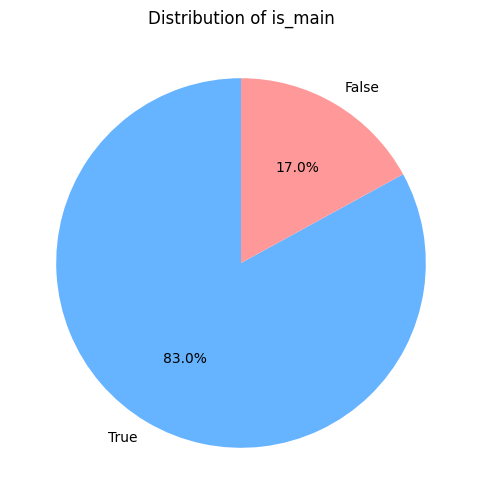

In [18]:
# Plotting the pie chart for is_main
plt.figure(figsize=(10, 6))
votes['is_main'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
plt.title('Distribution of is_main')
plt.ylabel('')  # Hide the y-label
plt.show()

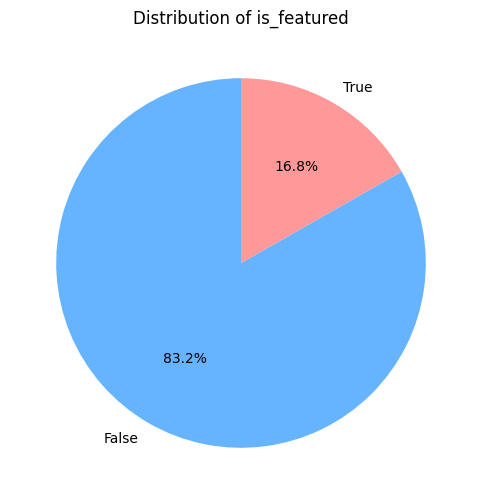

In [19]:
# Plotting the pie chart for is_featured
plt.figure(figsize=(10, 6))
votes['is_featured'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
plt.title('Distribution of is_featured')
plt.ylabel('')  # Hide the y-label
plt.show()

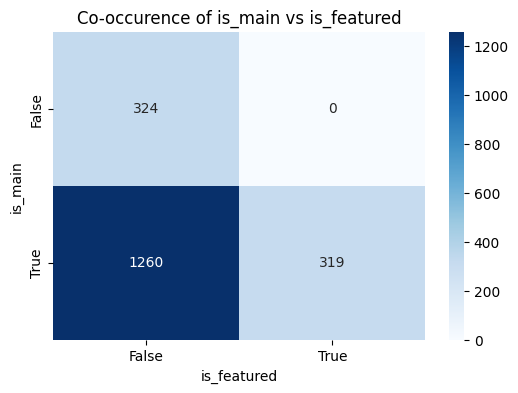

In [20]:
# Create a contingency table to explore the relationship between is_main and is_featured
contingency_table = pd.crosstab(votes['is_main'], votes['is_featured'])

# Plot the relationship using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(contingency_table, annot=True, cmap="Blues", fmt="d")
plt.title("Co-occurence of is_main vs is_featured")
plt.xlabel('is_featured')
plt.ylabel('is_main')
plt.show()

In [21]:
# Since when is_main is True, is_featured is also always true, the feature is_featured is irrelavant, so let's drop it
votes.drop('is_featured', axis=1, inplace=True)

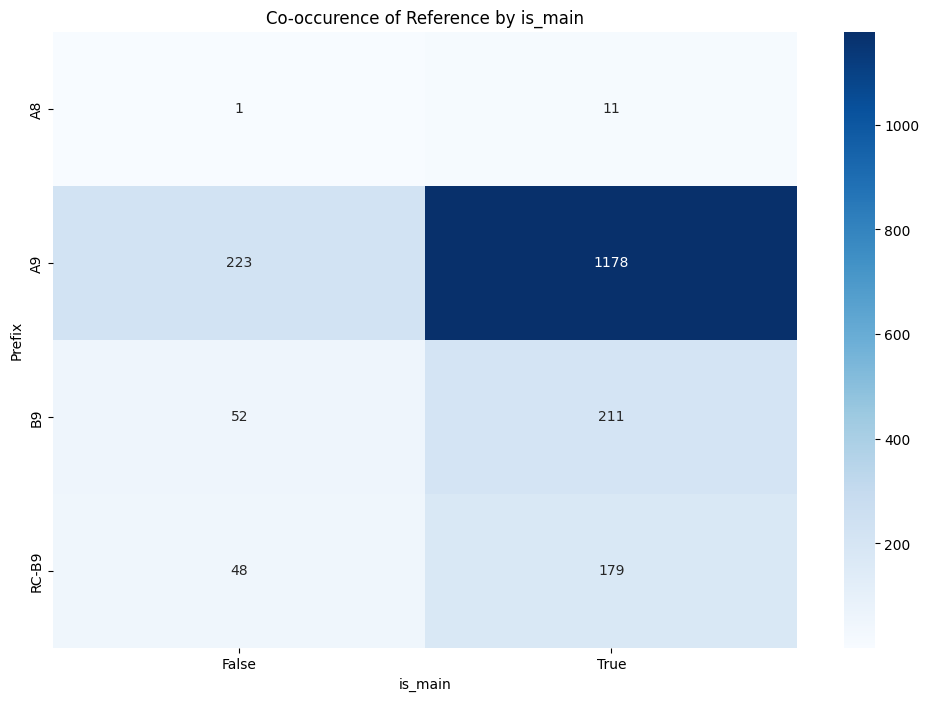

In [22]:
# Redesign the reference column with the following rules
def create_reference_prefix(reference):

    # If there is no reference, set the reference to Unknown
    if pd.isna(reference):
        return 'Unknown'

    # If the reference starts with "RC-", retrieve the first 5 characters 
    elif reference.startswith('RC-'):
        return reference[:5]

    # Otherwise, retrieve the first 2 characters
    else:
        return reference[:2]

# Recreate the feature
votes['reference'] = votes['reference'].apply(create_reference_prefix)

# Create a contingency table of reference and is_main
heatmap_data = pd.crosstab(votes['reference'], votes['is_main'])

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Co-occurence of Reference by is_main')
plt.xlabel('is_main')
plt.ylabel('Prefix')
plt.xticks(rotation=0)
plt.show()

## 2. Votes ID URL Mapping
<a id="Votes-ID-URL-Mapping"></a>

In [23]:
# Visualize the votes_id_url_mapping dataset
votes_id_url_mapping

,id,url
0,152881,C9-0003/2023
1,127829,C9-0004/2021
2,166653,C9-0009/2024
3,168997,C9-0010/2024
4,139916,C9-0028/2022
...,...,...
1775,169197,https://www.europarl.europa.eu/doceo/document/...
1776,169182,https://www.europarl.europa.eu/doceo/document/...
1777,169187,https://www.europarl.europa.eu/doceo/document/...
1778,169153,https://www.europarl.europa.eu/doceo/document/...


In [24]:
# Replace the 'id' column in the votes_id_url_mapping dataset using the new IDs from 'id_bill_mapping'
votes_id_url_mapping['id_bill'] = votes_id_url_mapping['id'].map(id_bill_mapping)

# Remove the old "id" column
votes_id_url_mapping.drop("id", inplace=True, axis=1)

# Display the updated votes_id_url_mapping dataset to verify the changes
votes_id_url_mapping

,url,id_bill
0,C9-0003/2023,NaN
1,C9-0004/2021,NaN
2,C9-0009/2024,NaN
3,C9-0010/2024,NaN
4,C9-0028/2022,NaN
...,...,...
1775,https://www.europarl.europa.eu/doceo/document/...,1901.0
1776,https://www.europarl.europa.eu/doceo/document/...,1899.0
1777,https://www.europarl.europa.eu/doceo/document/...,1900.0
1778,https://www.europarl.europa.eu/doceo/document/...,1897.0


## 3. Votes Extract
<a id="Votes-Extract"></a>

In [25]:
# Visualize the votes_extract dataset
votes_extract

,content,markdown,metadata_title,metadata_description,metadata_robots,metadata_ogTitle,metadata_ogImage,metadata_ogLocaleAlternate,metadata_sourceURL,metadata_pageStatusCode,linksOnPage,comitee,legislative_content,proponents,title_extended,title_short,url
0,"Dear visitor,\n\nWe use analytics cookies to o...","Dear visitor,\n\nWe use analytics cookies to o...",REPORT on EU-African security cooperation in t...,REPORT on EU-African security cooperation in t...,"index, follow, noodp, noydir, notranslate",REPORT on EU-African security cooperation in t...,https://www.europarl.europa.eu/website/common/...,[],https://www.europarl.europa.eu/doceo/document/...,200.0,['https://www.europarl.europa.eu/privacy-polic...,Committee on Foreign Affairs,MOTION FOR A EUROPEAN PARLIAMENT RESOLUTION\no...,['Javier Nart'],REPORT on EU-African security cooperation in t...,A9-0129/2020,https://www.europarl.europa.eu/doceo/document/...
1,"Dear visitor,\n\nWe use analytics cookies to o...","Dear visitor,\n\nWe use analytics cookies to o...",REPORT with recommendations to the Commission ...,REPORT with recommendations to the Commission ...,"index, follow, noodp, noydir, notranslate",REPORT with recommendations to the Commission ...,https://www.europarl.europa.eu/website/common/...,[],https://www.europarl.europa.eu/doceo/document/...,200.0,['https://www.europarl.europa.eu/privacy-polic...,"Committee on Civil Liberties, Justice and Home...",REPORT with recommendations to the Commission ...,['Abir Al‑Sahlani'],REPORT with recommendations to the Commission ...,Report,https://www.europarl.europa.eu/doceo/document/...
2,"Dear visitor,\n\nWe use analytics cookies to o...","Dear visitor,\n\nWe use analytics cookies to o...",REPORT on discharge in respect of the implemen...,REPORT on discharge in respect of the implemen...,"index, follow, noodp, noydir, notranslate",REPORT on discharge in respect of the implemen...,https://www.europarl.europa.eu/website/common/...,[],https://www.europarl.europa.eu/doceo/document/...,200.0,['https://www.europarl.europa.eu/privacy-polic...,Committee on Budgetary Control,REPORT on discharge in respect of the implemen...,['Michal Wiezik'],REPORT on discharge in respect of the implemen...,Report - A9-0089/2024,https://www.europarl.europa.eu/doceo/document/...
3,"Dear visitor,\n\nWe use analytics cookies to o...","Dear visitor,\n\nWe use analytics cookies to o...",REPORT on discharge in respect of the implemen...,REPORT on discharge in respect of the implemen...,"index, follow, noodp, noydir, notranslate",REPORT on discharge in respect of the implemen...,https://www.europarl.europa.eu/website/common/...,[],https://www.europarl.europa.eu/doceo/document/...,200.0,['https://www.europarl.europa.eu/privacy-polic...,Committee on Budgetary Control,REPORT on discharge in respect of the implemen...,['Monika Hohlmeier'],Report on discharge in respect of the implemen...,Report on discharge in respect of the implemen...,https://www.europarl.europa.eu/doceo/document/...
4,"Dear visitor,\n\nWe use analytics cookies to o...","Dear visitor,\n\nWe use analytics cookies to o...",MOTION FOR A RESOLUTION on the rule of law sit...,MOTION FOR A RESOLUTION to wind up the debate ...,"index, follow, noodp, noydir, notranslate",MOTION FOR A RESOLUTION on the rule of law sit...,https://www.europarl.europa.eu/website/common/...,[],https://www.europarl.europa.eu/doceo/document/...,200.0,['https://www.europarl.europa.eu/privacy-polic...,NaN,European Parliament resolution on the rule of ...,"['Petri Sarvamaa', 'Monika Hohlmeier', 'Jeroen...",MOTION FOR A RESOLUTION on the rule of law sit...,B9-0319/2021,https://www.europarl.europa.eu/doceo/document/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1598,"Dear visitor,\n\nWe use analytics cookies to o...","Dear visitor,\n\nWe use analytics cookies to o...",MOTION FOR A RESOLUTION on the draft Commissio...,MOTION FOR A RESOLUTION pursuant to Rule 112(2...,"index, follow, noodp, noydir, notransl

In [26]:
# Drop the irrelevant columns
votes_extract.drop(['content', 'markdown', 'metadata_title', 'metadata_description', 'metadata_robots', 'metadata_ogTitle', 
                    'metadata_ogImage', 'metadata_ogLocaleAlternate', 'metadata_sourceURL', 'metadata_pageStatusCode', 'linksOnPage'],
                    inplace=True, axis=1)

In [27]:
# Check how many different raw committee values have been involved in crafting bills
votes_extract['comitee'].nunique()

113

In [28]:
# Let's show the full distribution of raw committees

# Set the display option to show all committees
pd.set_option('display.max_rows', None)

# Display the full distribution for the 'comitee' column
print(votes_extract['comitee'].value_counts())

# Reset this option to limit the output for other cells
pd.reset_option('display.max_rows')

comitee
Committee on Budgetary Control                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

## 4. Bills
<a id="Bills"></a>

In [29]:
# Merge the votes_id_url_mapping dataset with the votes_extract dataset, based on the URL
merged_data = pd.merge(votes_id_url_mapping, votes_extract, how='inner', left_on='url', right_on='url')

# Display the merged dataframe
merged_data.head()

,url,id_bill,comitee,legislative_content,proponents,title_extended,title_short
0,https://www.europarl.europa.eu/doceo/document/...,757.0,"Committee on Civil Liberties, Justice and Home...",REPORT\non the proposal for a regulation of th...,['Péter Niedermüller'],REPORT on the proposal for a regulation of the...,Report - A8-0392/2016
1,https://www.europarl.europa.eu/doceo/document/...,1773.0,"Committee on Civil Liberties, Justice and Home...",REPORT on the proposal for a directive of the ...,"[""Sophia in 't Veld""]",REPORT on the proposal for a directive of the ...,Report
2,https://www.europarl.europa.eu/doceo/document/...,1765.0,"Committee on Civil Liberties, Justice and Home...",REPORT\non the proposal for a regulation of th...,['Monica Macovei'],DRAFT EUROPEAN PARLIAMENT LEGISLATIVE RESOLUTI...,Report - A8-0212/2017
3,https://www.europarl.europa.eu/doceo/document/...,687.0,"Committee on Civil Liberties, Justice and Home...",REPORT on the proposal for a directive of the ...,"['Claude Moraes', 'Jean Lambert']",REPORT on the proposal for a directive of the ...,Blue Card Directive
4,https://www.europarl.europa.eu/doceo/document/...,1836.0,"Committee on Civil Liberties, Justice and Home...",REPORT\non the proposal for a regulation of th...,['Tanja Fajon'],REPORT on the proposal for a regulation of the...,Report - A8-0245/2017


In [30]:
# Merge the votes dataset with the newly created dataset, based on the bill ID, resulting in the bills dataset
bills = pd.merge(votes, merged_data, how='left', on='id_bill')

# Display the bills dataset
bills

,timestamp,display_title,reference,description,is_main,procedure_reference,procedure_title,id_bill,url,comitee,legislative_content,proponents,title_extended,title_short
0,2020-06-17 23:24:52,EC/Morocco Euro-Mediterranean aviation agreeme...,A9,Procédure d'approbation,False,2007/0181(NLE),EC/Morocco Euro-Mediterranean aviation agreeme...,200,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-12-14 14:49:19,EU-US air transport agreement,A9,Projet de décision du Conseil,True,2010/0112(NLE),EC/USA Air Transport Agreement: Protocol to am...,786,https://www.europarl.europa.eu/doceo/document/...,TRAN,RECOMMENDATION on the draft Council decision o...,['Council of the European Union'],RECOMMENDATION on the draft Council decision o...,EC-US air transport agreement
2,2020-06-17 23:24:52,EU/Jordan agreement: Euro-Mediterranean Aviati...,A9,Procédure d'approbation,False,2010/0180(NLE),EU/Jordan agreement: Euro-Mediterranean Aviati...,201,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-06-17 23:24:52,EU/Georgia Agreement: common aviation area,A9,Procédure d'approbation,False,2010/0186(NLE),EU/Georgia Agreement: common aviation area,203,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-06-17 23:24:52,EU/Moldova Common Aviation Area Agreement,A9,Procédure d'approbation,False,2012/0006(NLE),EU/Moldova Common Aviation Area Agreement,198,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1898,2024-04-25 12:51:39,Resolution on new allegations of Russian inter...,RC-B9,Proposition de résolution (ensemble du texte),True,2024/2696(RSP),Resolution on new allegations of Russian inter...,1902,https://www.europarl.europa.eu/doceo/document/...,NaN,JOINT MOTION FOR A RESOLUTION on new allegatio...,"['Michael Gahler', 'Vladimír Bilčík', 'Rasa Ju...",JOINT MOTION FOR A RESOLUTION on new allegatio...,Joint motion for a resolution
1899,2024-04-25 12:20:42,"Resolution on Azerbaijan, notably the repressi...",RC-B9,Proposition de résolution (ensemble du texte),True,2024/2698(RSP),"Resolution on Azerbaijan, notably the repressi...",1898,https://www.europarl.europa.eu/doceo/document/...,NaN,"European Parliament resolution on Azerbaijan, ...","['Michaela Šojdrová', 'Michael Gahler', 'David...","JOINT MOTION FOR A RESOLUTION on Azerbaijan, n...",Joint motion for a resolution - RC-B9-0227/2024
1900,2024-04-25 12:21:01,Resolution on the proposed repeal of the law b...,RC-B9,Proposition de résolution (ensemble du texte),True,2024/2699(RSP),Resolution on the proposed repeal of the law b...,1901,https://www.europarl.europa.eu/doceo/document/...,NaN,European Parliament resolution on the proposed...,"['Michael Gahler', 'David Lega', 'Tomáš Zdecho...",JOINT MOTION FOR A RESOLUTION\non the proposed...,Joint motion for a resolution - RC-B9-0228/2024
1901,2024-04-25 12:53:44,Resolution on attempts to reintroduce a foreig...,RC-B9,Proposition de résolution (ensemble du texte),True,2024/2703(RSP),Resolution on attempts to reintroduce a foreig...,1900,https://www.europarl.europa.eu/doceo/document/...,NaN,Joint motion for a resolution,"['Miriam Lexmann', 'Michael Gahler', 'Rasa Juk...",Joint motion for a resolution on attempts to r...,Joint motion for a resolution


In [31]:
# Check the structural information of the bills dataset, including column names, non-null counts, datatypes and size
bills.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1903 entries, 0 to 1902
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            1903 non-null   datetime64[ns]
 1   display_title        1902 non-null   object        
 2   reference            1903 non-null   object        
 3   description          1897 non-null   object        
 4   is_main              1903 non-null   bool          
 5   procedure_reference  1903 non-null   object        
 6   procedure_title      1902 non-null   object        
 7   id_bill              1903 non-null   int32         
 8   url                  1577 non-null   object        
 9   comitee              1312 non-null   object        
 10  legislative_content  1469 non-null   object        
 11  proponents           1577 non-null   object        
 12  title_extended       1469 non-null   object        
 13  title_short          1469 non-nul

In [32]:
# Check for duplicated rows in the bills dataset
duplicates = bills.duplicated()

# Display the count of duplicated rows
print(f"Number of duplicated rows in bills: {duplicates.sum()}")

Number of duplicated rows in bills: 0


In [33]:
# Adjust display options to show the full content of the text columns
pd.set_option('display.max_colwidth', None)

# Select the columns to investigate
columns_to_display = ['display_title', 'procedure_title', 'legislative_content', 'title_extended', 'title_short']

# Display the first 40 rows of the specified textual columns
bills[columns_to_display].head(40)

,display_title,procedure_title,legislative_content,title_extended,title_short
0,"EC/Morocco Euro-Mediterranean aviation agreement, protocol following the accession of Bulgaria and Romania","EC/Morocco Euro-Mediterranean aviation agreement, protocol following the accession of Bulgaria and Romania",NaN,NaN,NaN
1,EU-US air transport agreement,EC/USA Air Transport Agreement: Protocol to amend the Agreement,"RECOMMENDATION on the draft Council decision on the conclusion, on behalf of the European Union, of the Protocol to amend the Air Transport Agreement between the United States of America and the European Community and its Member States","RECOMMENDATION on the draft Council decision on the conclusion, on behalf of the European Union, of the Protocol to amend the Air Transport Agreement between the United States of America and the European Community and its Member States",EC-US air transport agreement
2,EU/Jordan agreement: Euro-Mediterranean Aviation Agreement,EU/Jordan agreement: Euro-Mediterranean Aviation Agreement,NaN,NaN,NaN
3,EU/Georgia Agreement: common aviation area,EU/Georgia Agreement: common aviation area,NaN,NaN,NaN
4,EU/Moldova Common Aviation Area Agreement,EU/Moldova Common Aviation Area Agreement,NaN,NaN,NaN
5,International public procurement instrument,International public procurement instrument,"REGULATION OF THE EUROPEAN PARLIAMENT AND OF THE COUNCIL on the access of third-country economic operators, goods and services to the Union’s procurement market and procedures supporting negotiations on access of Union economic operators, goods and services to the procurement markets of third countries",SECOND REPORT\non the proposal for a regulation of the European Parliament and of the Council on the access of third-country goods and services to the Union’s internal market in public procurement and procedures supporting negotiations on access of Union goods and services to the public procurement markets of third countries,Report - A9-0337/2021
6,EU/Israel Euro-Mediterranean Aviation Agreement,EU/Israel Euro-Mediterranean Aviation Agreement,NaN,NaN,NaN
7,Arrangement with Iceland on the modalities of its participation in the European Asylum Support Office,Arrangement with Iceland on the modalities of its participation in the European Asylum Support Office,RECOMMENDATION on the draft Council decision on the conclusion of the Arrangement between the European Union and the Republic of Iceland on the modalities of its participation in the European Asylum Support Office,RECOMMENDATION on the draft Council decision on the conclusion of the Arrangement between the European Union and the Republic of Iceland on the modalities of its participation in the European Asylum Support Office,Arrangement between the European Union and the Republic of Iceland on the modalities of its participation in the European Asylum Support Office
8,EC/Indonesia Framework Agreement on Comprehensive Partnership and Cooperation: accession of Croatia to the EU. Protocol,EC/Indonesia Framework Agreement on Comprehensive Partnership and Cooperation: accession of Croatia to the EU. Protocol,"RECOMMENDATION on the draft Council decision on the conclusion, on behalf of the Union and its Member States, of the Accession Protocol to the Framework Agreement on Comprehensive Partnership and Cooperation between the European Community and its Member States, of the one part, and the Republic of Indonesia, of the other part, to take account of the accession of the Republic of Croatia to the European Union","RECOMMENDATION on the draft Council decision on the conclusion, on behalf of the Union and its Member States, of the Accession Protocol to the Framework Agreement on Comprehensive Partnership and Cooperation between the European Community and its Member States, of the one part, and the Republic of Indonesia, of the other part, to take account of the accession of the Republic of Croatia to the European Union",Accession Protocol to the Framework Agreement on Comprehe

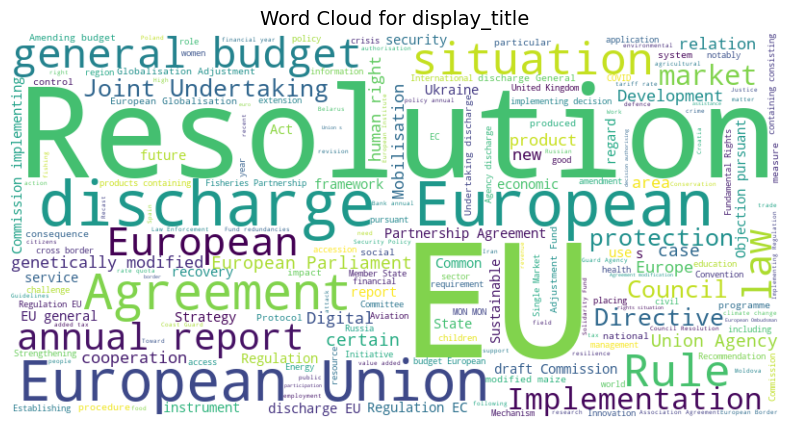

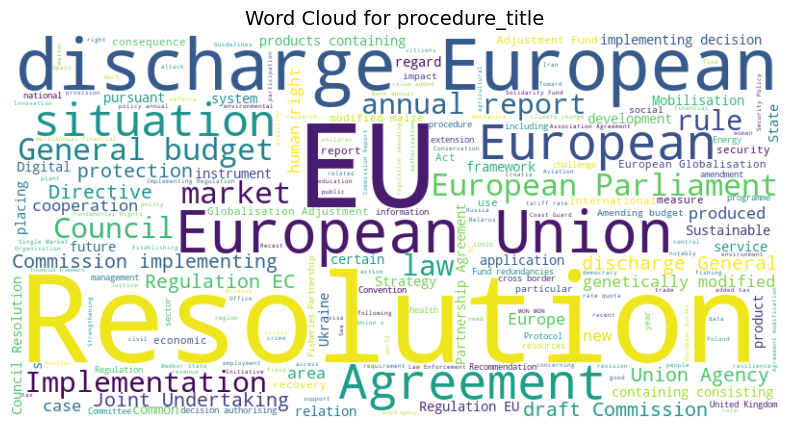

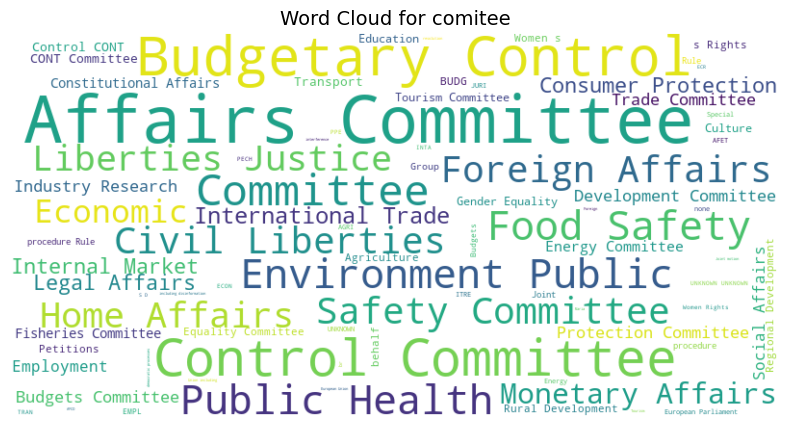

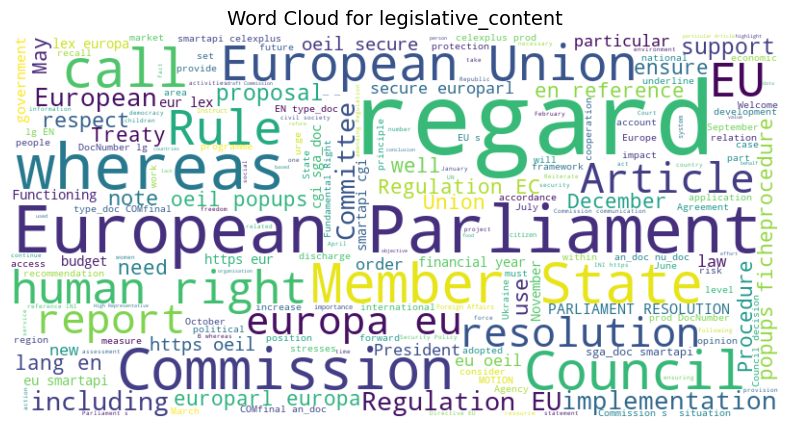

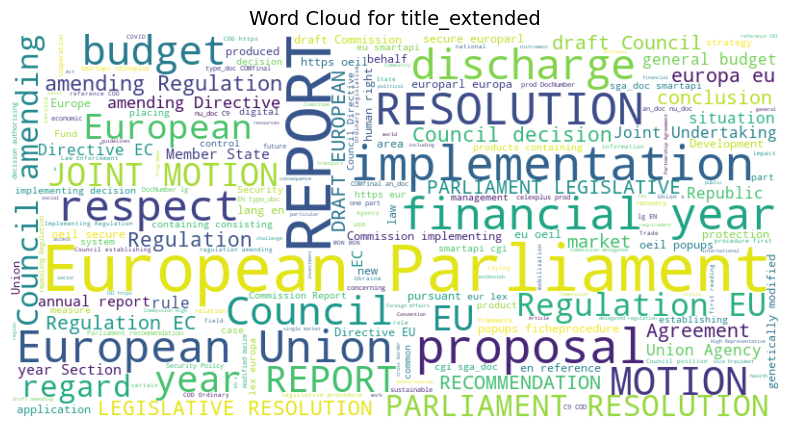

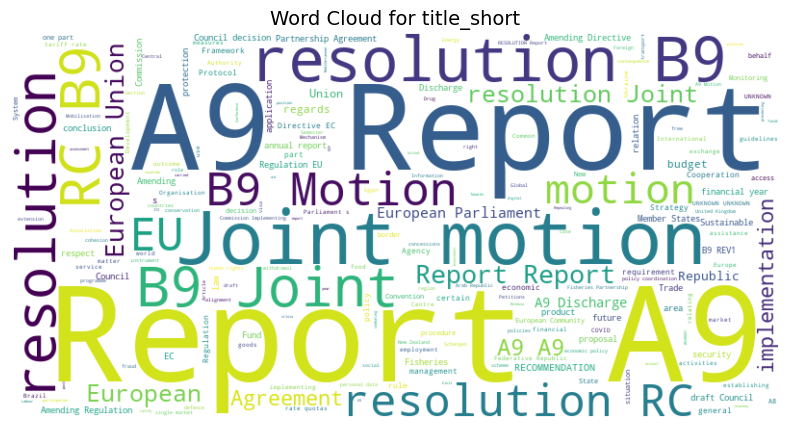

In [34]:
# List of textual columns to generate word clouds for
textual_columns = ['display_title', 'procedure_title', 'comitee', 'legislative_content', 'title_extended', 'title_short']

# Function to generate and plot a word cloud
def plot_wordcloud(text, column_name):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {column_name}', fontsize=14)
    plt.show()

# Loop through each column and generate the word cloud
for column in textual_columns:
    
    # Drop NaN values and join all text entries in the column into a single string
    text = ' '.join(bills[column].dropna().astype(str))
    print('\n')
    plot_wordcloud(text, column)

In [35]:
# Create a new feature called "text"
# This feature is constructed by first taking 'legislative_content', 
# if it's empty then 'display_title', and if that is also empty then 'procedure_title', 
# if that's empty then 'title_extended' and if that is also empty then 'title_short'
bills.loc[:, 'text'] = bills['legislative_content'].combine_first(bills['display_title']).combine_first(bills['procedure_title']).combine_first(bills['title_extended']).combine_first(bills['title_short'])

# Remove the unnecessary features
bills = bills.drop(columns=['reference', 'description', 'url', 'comitee',  'legislative_content', 'display_title', 'procedure_title', 'proponents', 'title_extended', 'title_short', 'is_main'])

# Display the resulting bills dataset
bills

,timestamp,procedure_reference,id_bill,text
0,2020-06-17 23:24:52,2007/0181(NLE),200,"EC/Morocco Euro-Mediterranean aviation agreement, protocol following the accession of Bulgaria and Romania"
1,2021-12-14 14:49:19,2010/0112(NLE),786,"RECOMMENDATION on the draft Council decision on the conclusion, on behalf of the European Union, of the Protocol to amend the Air Transport Agreement between the United States of America and the European Community and its Member States"
2,2020-06-17 23:24:52,2010/0180(NLE),201,EU/Jordan agreement: Euro-Mediterranean Aviation Agreement
3,2020-06-17 23:24:52,2010/0186(NLE),203,EU/Georgia Agreement: common aviation area
4,2020-06-17 23:24:52,2012/0006(NLE),198,EU/Moldova Common Aviation Area Agreement
...,...,...,...,...
1898,2024-04-25 12:51:39,2024/2696(RSP),1902,"JOINT MOTION FOR A RESOLUTION on new allegations of Russian interference in the European Parliament, in the upcoming EU elections and the impact on the European Union"
1899,2024-04-25 12:20:42,2024/2698(RSP),1898,"European Parliament resolution on Azerbaijan, notably the repression of civil society and the cases of Dr Gubad Ibadoghlu and Ilhamiz Guliyev\n\n([2024/2698(RSP)](https://oeil.secure.europarl.europa.eu/oeil/popups/ficheprocedure.do?lang=en&reference=2024/2698(RSP))\n)\n\nThe European Parliament,\n\n– having regard to its previous resolutions on Azerbaijan,\n\n– having regard to Rules 144(5) and 132(4) of its Rules of Procedure,\n\nA. whereas Azerbaijan has intensified its repression of civil society, activists and the remaining independent media, such as Abzas Media, through detentions and judicial harassment; whereas civil society organisations currently list nearly 300 political prisoners in Azerbaijan;\n\nB. whereas Gubad Ibadoghlu, a political economist and opposition figure, was arrested by Azerbaijani authorities in July 2023 and remained in detention until 22 April 2024, when he was transferred to house arrest; whereas his health has deteriorated significantly since his arrest, as a result of torture, inhumane detention conditions and refusal of adequate medical care, thus endangering his life;\n\nC. whereas Ilhamiz Guliyev, a human rights defender, was arbitrarily arrested on 4 December 2023 on dubious accusations of drug trafficking after he testified as whistleblower about the police tampering with evidence against government critics; whereas he is facing up to 12 years in prison;\n\n1. Urges Azerbaijan to immediately and unconditionally release Ilhamiz Guliyev; notes that Gubad Ibadoghlu has been released and placed under house arrest and calls on the authorities to lift the travel ban and drop all charges against him; calls on Azerbaijan to urgently ensure that he receives an independent medical examination by a doctor of his own choosing and to allow him to receive treatment abroad;\n\n2. Urges Azerbaijan to immediately and unconditionally release all other political prisoners, including Tofig Yagublu, Akif Gurbanov, Bakhtiyar Hajiyev, human rights defenders and journalists Ulvi Hasanli, Sevinj Vagifgizi, Nargiz Absalamova, Hafiz Babali, Elnara Gasimova, Aziz Orujov, Rufat Muradli, Avaz Zeynalli, Elnur Shukurov, Alasgar Mammadli, Farid Ismayilov, as well as EU and other nationals;\n\n3. Reminds the Azerbaijani authorities of their obligations to respect human dignity and fundamental freedoms and calls on them to repeal repressive legislation that drives independent non-governmental organisations and media to the margins of the law;\n\n4. Considers that the ongoing human rights violations in Azerbaijan are incompatible with the country’s preparations to host COP29; demands that the organisers ensure that human rights, fundamental freedoms and effective civil society participation are fully enshrined and guaranteed in the Host Country Agreement;\n\n5. Calls on the Commission to consider suspending the strategic partnership with Azerbaijan in the field of energy; insists on making any future partnership agreement con

In [36]:
# Check the number of missing values per feature
bills.isna().sum()

timestamp              0
procedure_reference    0
id_bill                0
text                   0
dtype: int64

In [37]:
# Visualize an example of a bill's raw text
bills['text'][292]

'Resolution on the proposed new criminal code of Indonesia'

### 4.1. Text Cleaning
<a id="Text-Cleaning"></a>

In [38]:
def clean_bill(text):
    
    # Step 1: Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Step 2: Remove line breaks
    text = text.replace('\n', ' ')
    
    # Step 3: Remove square bracket references like [#_ftn1]
    text = re.sub(r'\[\s*#_ftn\d+\s*\]', '', text)
    
    # Step 4: Remove non-breaking spaces and other special characters
    text = text.replace('\xa0', ' ')
    
    # Step 5: Remove any leftover markdown-like references
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    
    # Step 6: Remove excessive whitespaces
    text = ' '.join(text.split())

    # Step 7: Lowercase everything
    text = text.lower()

    # Step 8: Remove possessive "'s"
    text = re.sub(r"\b(\w+)'s\b", r'\1', text)
    
    # Step 9: Remove all non-alphabetic characters except dashes, numbers, and spaces
    text = re.sub(r'[^a-zA-Z0-9\s\-]', '', text)

    # Step 10: Remove dashes that are not surrounded by letters or numbers
    text = re.sub(r'(?<![a-zA-Z0-9])-|-(?![a-zA-Z0-9])', '', text)

    # Step 11: Remove leading and trailing whitespaces
    text = text.strip()

    # Step 12: Remove any extra whitespace
    text = re.sub(r'\s+', ' ', text)

    # Step 13: Remove letters or numbers surrounded by spaces
    text = re.sub(r'\s+[a-zA-Z0-9]\s+', ' ', text)
    
    return text


# Apply the function to the 'text' column
bills['text'] = bills['text'].apply(clean_bill)

In [39]:
# Visualize the same bill, this time text-cleaned
bills['text'][292]

'resolution on the proposed new criminal code of indonesia'

### 4.2. Stopwords Removal
<a id="Stopwords-Removal"></a>

In [40]:
# Retrieving the English stopwords about to be removed from the bills text
ENGLISH_STOP_WORDS

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

In [41]:
# Function to remove stopwords
def remove_stopwords(text, stop_words):
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

# Apply stopword removal to each row in the 'text' column
bills['text'] = bills['text'].apply(lambda x: remove_stopwords(x, ENGLISH_STOP_WORDS))

In [42]:
# Preview the results, in the same example bill
bills['text'][292]

'resolution proposed new criminal code indonesia'

### 4.3. Lemmatization
<a id="Lemmatization"></a>

In [43]:
# Load the transformer-based spaCy model
nlp = spacy.load("en_core_web_trf")

# Initialize tqdm for pandas
tqdm.pandas()

# Function to lemmatize text using the transformer-based model
def lemmatize(text):
    doc = nlp(text)  # Process the text using spaCy
    lemmatized_text = ' '.join([token.lemma_ for token in doc])  # Join the lemmatized tokens
    # Remove extra whitespaces around hyphens
    lemmatized_text = re.sub(r'\s*-\s*', '-', lemmatized_text)
    return lemmatized_text

# Apply the lemmatization function to the 'text' column with a progress bar
bills['text'] = bills['text'].progress_apply(lemmatize)

100%|██████████| 1903/1903 [07:55<00:00,  4.00it/s]


In [44]:
# Preview the results, in the same example bill
bills['text'][292]

'resolution propose new criminal code indonesia'

### 4.4. Bill Text Exploration
<a id="Bill-Text-Exploration"></a>

In [45]:
# Check if there are any bills with empty text
bills["text"].isna().sum()

0

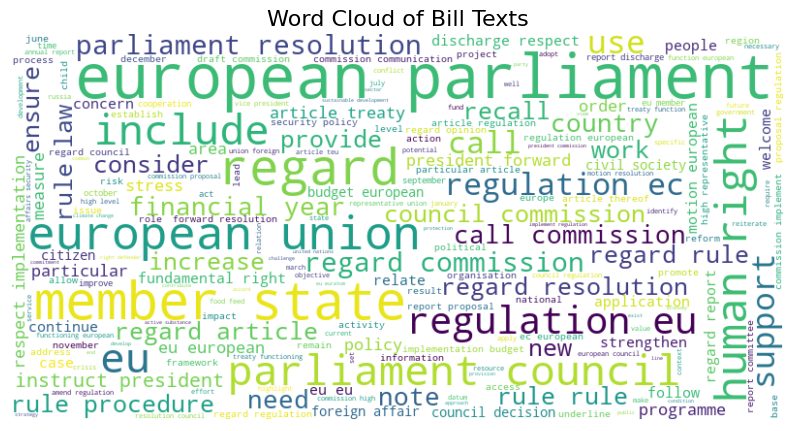

In [46]:
# Combine all the text in the 'text' column into a single string
text = ' '.join(bills['text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axes for a cleaner look

# Add a title to the plot
plt.title('Word Cloud of Bill Texts', fontsize=16)

plt.show()

Vocabulary dimensionality: 17179


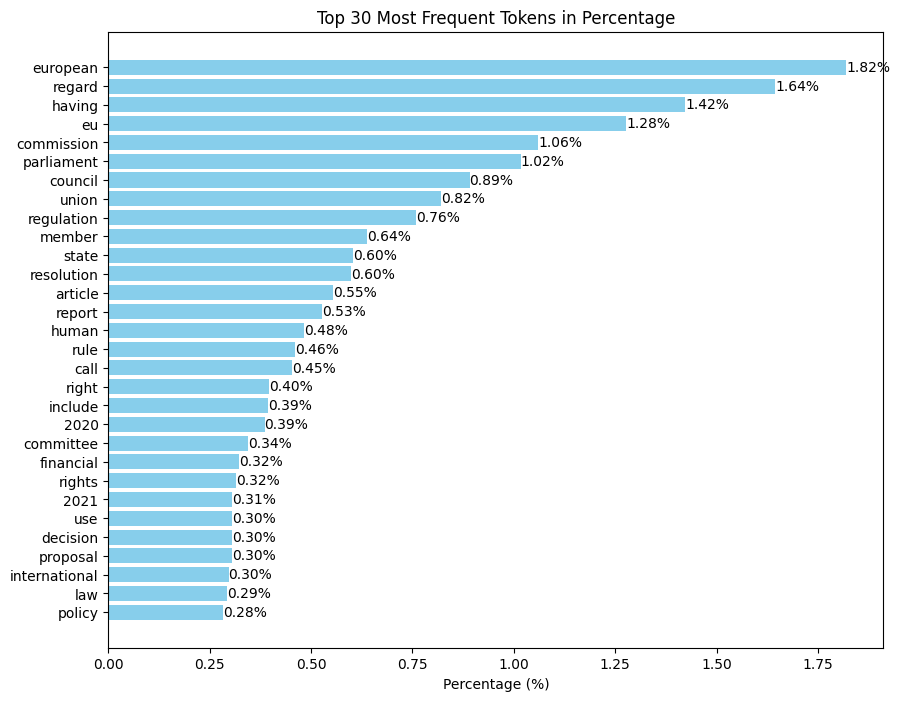

In [47]:
# Split the text into tokens
tokens = text.split()

# Count the frequency of each token
token_counts = Counter(tokens)

# Convert the token counts to a DataFrame
token_freq_df = pd.DataFrame(token_counts.items(), columns=['token', 'count'])

# Calculate the total number of tokens
total_words = token_freq_df['count'].sum()

# Print the total number of unique tokens (vocabulary dimensionality)
print(f"Vocabulary dimensionality: {len(token_freq_df)}")

# Calculate the percentage of each token
token_freq_df['percentage'] = (token_freq_df['count'] / total_words) * 100

# Sort the DataFrame by percentage
token_freq_df = token_freq_df.sort_values(by='percentage', ascending=False)

# Get the top 30 most frequent tokens
top_30_most_frequent = token_freq_df.head(30)

# Plot the top 30 most frequent tokens
plt.figure(figsize=(10, 8))
plt.barh(top_30_most_frequent['token'], top_30_most_frequent['percentage'], color='skyblue')
plt.xlabel('Percentage (%)')
plt.ylabel('')
plt.title('Top 30 Most Frequent Tokens in Percentage')
plt.gca().invert_yaxis()  # To display the highest percentage at the top

# Add percentage labels on the bars
for index, value in enumerate(top_30_most_frequent['percentage']):
    plt.text(value, index, f'{value:.2f}%', va='center')

plt.show()

## 5. Exporting Dataset
<a id="Exporting-Dataset"></a>

In [48]:
# Export the bills dataset in its current stage to the corresponding local folder
bills.to_csv("../datasets/second_stage/4_bills/bills.csv", index=False)

# Save the id_bill_mapping variable for later use
with open('../datasets/second_stage/4_bills/id_bill_mapping.pkl', 'wb') as f:
    pickle.dump(id_bill_mapping, f)